In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

In [2]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[5])}")


Length of the first datax array: 698


In [3]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)


[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


In [4]:
# set up the class
cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)


In [5]:
print(len(datax_list[0]))

749


In [6]:
# check with the lenstronomy package directly
realsize = 749
grid = np.linspace(0, realsize-1, realsize)
grid = grid * 0.2

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_list[0]*0.2**2,
                          'f_x': datax_list[0], 'f_y': datay_list[0]}]
lensModel_real = LensModel(lens_model_list=lens_model_list2, z_source=1, z_lens=0.5)

# Use lens equation solver for verification
solver2 = LensEquationSolver(lensModel_real)
coord = (67.22561783145142,72.83653950135216)
img_po = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=0.2, search_window=100, verbose=False, x_center=90, y_center=70)
print(img_po)
img_mycode = cluster.image_position(coord[0], coord[1], 0)
print(img_mycode)


(array([130.90570749, 119.37227644, 123.09639191, 108.9624652 ,
       107.36913457, 111.70002398]), array([70.65962589, 53.17209047, 98.35351745, 79.99845342, 71.00786791,
       89.99207943]))
(array([130.90570749, 119.37227644, 123.09639191, 108.9624652 ,
       107.36913457, 111.70002398]), array([70.65962589, 53.17209047, 98.35351745, 79.99845342, 71.00786791,
       89.99207943]))


In [7]:
# dt and mag data

mag = (1.49972905, 7.42332916, -11.5028191, -4.07344553, -3.28229147, 3.14782126, 3.57746724)
dt =[0.0, 3464.586642261129, 24012.56500505423, 25331.258614414837, 25887.914411486126]
dt_ref = [0.0, 88594.90558064939, 91797.85200701188, 91896.81383935199, 92121.65322824288, 92551.52745506703, 93534.55033071572]

In [8]:
src_guess = (81,71.3)
chi_sq = cluster.chi_squared(src_guess, dt, index = 0)
print(chi_sq)

0.0


In [ ]:
# localization of source position given the index of cluster
x_approx, y_approx, chi_sq = cluster.localize_known_cluster_diffevo(dt_true = dt, index = 1)
print(x_approx, y_approx, chi_sq)
print((x_approx-src_guess[0])**2 + (y_approx-src_guess[1])**2)


In [ ]:

# localization of source position with unknown cluster
index, src_pos, chi_sq , src_guess, chi_sqs= cluster.localize_diffevo(dt_true = dt)
print(index, src_pos, chi_sq)

0 [81.00000038017119, 71.29999998618307] 2.1059426626038668e-05


In [9]:
# localization of source position with unknown cluster for multiple sources
src = pd.read_csv('src_pos_for_distribution_2nd.csv')
src_pos_test,index_test = src[['x', 'y']].values, src['indices'].values

for i in range(48, 60):
    img = cluster.image_position(src_pos_test[i][0], src_pos_test[i][1], index_test[i])
    dt = cluster.time_delay(img[0], img[1], index_test[i])
    print(f'Finding source {i}')
    index, src_pos, chi_sq , _, _ = cluster.localize_diffevo(dt_true=dt)
    src.at[i, 'localized_index'] = index
    src.at[i, 'localized_x'] = src_pos[0]
    src.at[i, 'localized_y'] = src_pos[1]
    src.at[i, 'localized_chi_sq'] = chi_sq
    src.to_csv('src_pos_for_distribution_2nd.csv', index=False)



Finding source 48
Finding source 49
Finding source 50
Finding source 51
Finding source 52
Finding source 53
Finding source 54
Finding source 55
Finding source 56
Finding source 57
Finding source 58
Finding source 59


In [11]:
# Checking the chi squared values for the sources
src_check = pd.read_csv('src_pos_for_distribution.csv')
line_check = 47
index_check = src_check.at[line_check, 'indices']
print(index_check)
x,y = src_check.at[line_check, 'x'], src_check.at[line_check, 'y']
print(x,y, index_check)
img = cluster.image_position(x, y, index_check)
print(img)
dt_check = cluster.time_delay(img[0], img[1], index_check)
x_guess, y_guess = src_check.at[line_check, 'localized_x'], src_check.at[line_check, 'localized_y']
index_guess = src_check.at[line_check, 'localized_index']
img_guess = cluster.image_position(x_guess, y_guess, 4)
print(x_guess, y_guess, index_guess)
print(img_guess)
diff = cluster.chi_squared([x_guess,y_guess], dt_check, 5)
print(diff)


4
66.38415789570078 72.72044649674007 4
(array([129.55701136, 123.51389146, 122.65325983, 109.68022657,
       108.54981428, 113.14524196]), array([69.98295887, 57.61013677, 96.77264003, 78.66950378, 71.36303424,
       90.3524465 ]))
66.38415791614607 72.72044646405331 0.0
(array([129.55701139, 123.51389159, 122.65325977, 109.68022651,
       108.54981425, 113.14524193]), array([69.98295866, 57.61013683, 96.77264015, 78.66950371, 71.36303438,
       90.35244656]))
9.673587503082613e-06


In [7]:
# calculating the differnce in (x,y) and (localized_x,localized_y) for the sources in csv file
src_check = pd.read_csv('src_pos_for_distribution_2nd.csv')
diff = []
true_x, true_y = src_check['x'].values, src_check['y'].values
localized_x, localized_y = src_check['localized_x'].values, src_check['localized_y'].values
src_check['diff'] = np.sqrt((true_x-localized_x)**2 + (true_y-localized_y)**2)
print(src_check['diff'])
src_check.to_csv('src_pos_for_distribution_2nd.csv', index=False)


0     3.993612e-07
1     2.330763e-07
2     3.560470e-08
3     1.089944e-07
4     9.003790e-08
5     1.342419e-07
6     3.230082e-08
7     1.378013e-06
8     5.404881e-08
9     2.174466e-08
10    4.859379e-08
11    6.420375e-08
12    2.836368e+01
13    3.590169e-08
14    3.860651e-07
15    4.411562e-08
16    3.384625e-07
17    9.616610e-08
18    1.503528e-07
19    1.849361e-07
20    7.948299e-08
21    3.643106e-08
22    9.545225e-08
23    1.541214e-08
24    4.518463e-08
25    4.426587e-08
26    3.792242e-08
27    4.376833e-08
28    7.104430e-08
29    6.478393e-08
30    4.073443e-07
31    2.664296e-07
32    4.153437e-07
33    2.561492e-07
34    3.848598e-07
35    1.686387e-07
36    8.445183e-08
37    5.282015e-08
38    2.404607e-08
39    9.314009e-08
40    1.117137e-08
41    8.278859e-08
42    9.537627e-08
43    2.342475e-08
44    9.086360e-07
45    8.547087e-08
46    3.466648e-07
47    5.196260e-07
48    2.254496e-07
49    5.549219e-07
50    1.443201e-07
51    2.641722e-08
52    1.3184

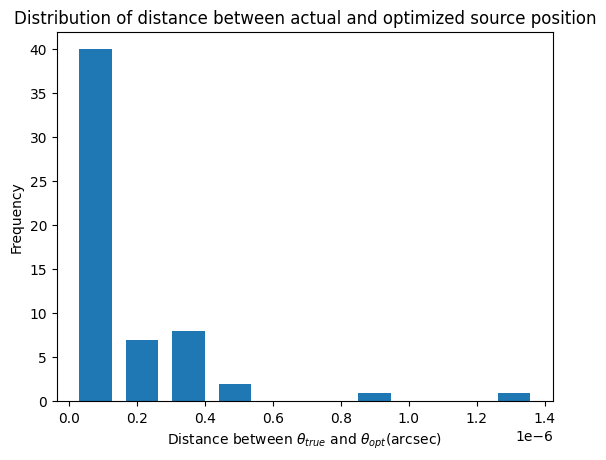

In [48]:
# plot distribution of chi squared values from the csv file
src = pd.read_csv('src_pos_for_distribution_2nd.csv')
diff = src['diff'].values
# Omit the chi squared values that is larger than 1
diff = diff[diff < 1]

plt.hist(diff, bins=10, rwidth=0.7)
plt.xlabel(r'Distance between $\theta_{true}$ and $\theta_{opt}$(arcsec)')
plt.ylabel('Frequency')
plt.title('Distribution of distance between actual and optimized source position')
#plt.figtext(0.5, -0.1, 'Figure 4: Distribution of difference in actual and optimized source position in arcsec.\nMost of the optimized source positions have discrepancy smaller than $10^{-7}$ arcsec, which\nindicates again the high accuracy of localization which is nearly pinpointing the source location. \nNote that the one event with fail localization is opt out as the identification of clsuter also failed.', ha='center', fontsize = 8)
plt.show()